<a href="https://colab.research.google.com/github/sagurjar027/NLP_project_Emotional_mesages/blob/main/nlp_assignment(emotional).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Basic
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Visualization
from collections import Counter
from wordcloud import WordCloud

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [29]:
# NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df = pd.read_csv("text.csv")
df.sample(3)

,Unnamed: 0,text,label
251586,251586,i feel like these are amazing quality and stan...,1
144524,144524,im feeling nostalgic about my workspace since ...,2
360890,360890,i wanted to raise by sharing this is not about...,1


In [7]:
df.shape

(416809, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [9]:
df.isnull().sum()

,0
Unnamed: 0,0
text,0
label,0


In [10]:
#drop null values label
df.dropna(inplace=True)

In [11]:
# Drop the extra column
df = df.drop(columns=["Unnamed: 0"])

# Convert label to int
df["label"] = df["label"].astype(int)

print(df.shape)
df.head()

(416809, 2)


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [12]:
 print(df['label'].value_counts())

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


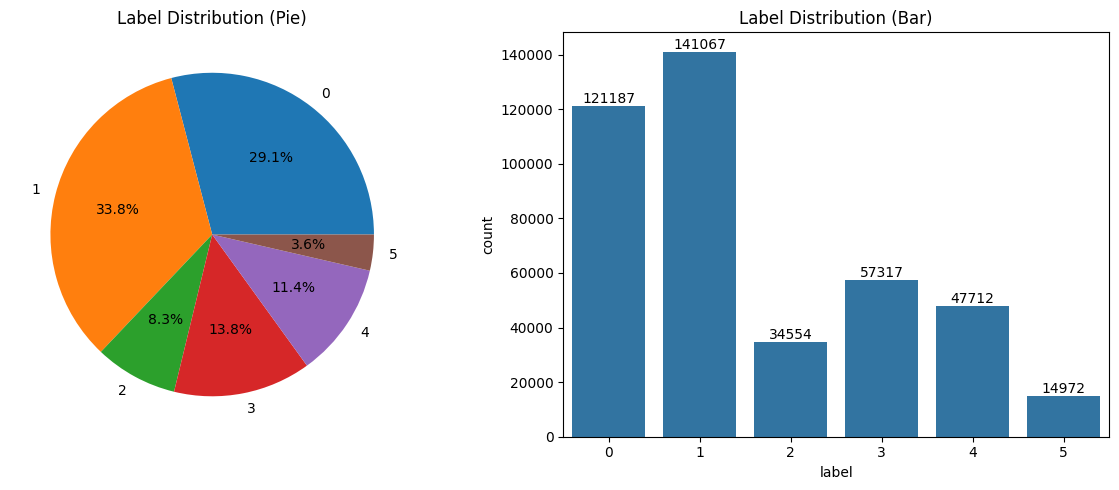

In [13]:
# Count of labels
label_counts = df['label'].value_counts().sort_index()

plt.figure(figsize=(12,5))

# Pie chart
plt.subplot(1,2,1)
df['label'].value_counts().sort_index().plot.pie(autopct='%1.1f%%', ylabel='')
plt.title("Label Distribution (Pie)")

# Bar chart with annotations
plt.subplot(1,2,2)
ax = sns.countplot(x='label', data=df, order=label_counts.index)
plt.title("Label Distribution (Bar)")
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [14]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy English model (disable things we don't need)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat", "tagger"])

def lemmatize_texts(texts):
    results = []
    for doc in nlp.pipe(texts, batch_size=50):
        tokens = [token.lemma_.lower() for token in doc
                  if token.is_alpha and token.lemma_.lower() not in STOP_WORDS]
        results.append(" ".join(tokens))
    return results

df['clean_text'] = lemmatize_texts(df['text'].astype(str))
df[['text', 'clean_text', 'label']].head()


/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,text,clean_text,label
0,i just feel really helpless and heavy hearted,feel helpless heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,ve enjoyed able slouch relax unwind frankly ne...,0
2,i gave up my internship with the dmrg and am f...,gave internship dmrg feeling distraught,4
3,i dont know i feel so lost,nt know feel lost,0
4,i am a kindergarten teacher and i am thoroughl...,kindergarten teacher thoroughly weary job havi...,4


In [15]:
df.to_csv("cleaned_emotion_dataset.csv", index=False)

In [17]:
X = df['clean_text']
y = df['label']

In [20]:
#conert x in 2d
# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'].tolist())

# Sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'].tolist())

# Padding (2D output)
MAX_LEN = int(np.percentile([len(s) for s in sequences], 90))
MAX_LEN = max(20, MAX_LEN)   # ensure min length 20
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print("X shape:", X.shape)   # should be (416809, MAX_LEN)

X shape: (416809, 20)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (333447, 20)
X_test shape: (83362, 20)
y_train shape: (333447,)
y_test shape: (83362,)


In [24]:
# Parameters
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)  # number of words in vocab
embedding_dim = 100   # can be tuned
lstm_units = 128      # number of LSTM units
num_classes = len(np.unique(y))  # should be 6 because we have six emotions

# Build model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X.shape[1]),
    Bidirectional(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('best_bilstm.h5', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=15,
    batch_size=128,
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/15
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8003 - loss: 0.5269
Epoch 1: val_loss improved from inf to 0.12333, saving model to best_bilstm.h5


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 407s 166ms/step - accuracy: 0.8003 - loss: 0.5268 - val_accuracy: 0.9312 - val_loss: 0.1233
Epoch 2/15
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9299 - loss: 0.1322
Epoch 2: val_loss improved from 0.12333 to 0.11060, saving model to best_bilstm.h5


2345/2345 ━━━━━━━━━━━━━━━━━━━━ 396s 169ms/step - accuracy: 0.9299 - loss: 0.1322 - val_accuracy: 0.9357 - val_loss: 0.1106
Epoch 3/15
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9358 - loss: 0.1118
Epoch 3: val_loss did not improve from 0.11060
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 398s 170ms/step - accuracy: 0.9358 - loss: 0.1118 - val_accuracy: 0.9349 - val_loss: 0.1151
Epoch 4/15
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9379 - loss: 0.1032
Epoch 4: val_loss did not improve from 0.11060
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 435s 167ms/step - accuracy: 0.9379 - loss: 0.1032 - val_accuracy: 0.9365 - val_loss: 0.1128
Epoch 5/15
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9397 - loss: 0.0984
Epoch 5: val_loss did not improve from 0.11060
2345/2345 ━━━━━━━━━━━━━━━━━━━━ 384s 164ms/step - accuracy: 0.9397 - loss: 0.0984 - val_accuracy: 0.9351 - val_loss: 0.1222
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [30]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('best_bilstm.h5')
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,252,360 (4.78 MB)

 Trainable params: 1,251,846 (4.78 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 2 (12.00 B)

In [31]:
y_pred_probs = best_model.predict(X_test)

# Convert to class labels (0–5)
y_pred = np.argmax(y_pred_probs, axis=1)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 87s 33ms/step


Test Accuracy: 0.9321633358124805

Classification Report:

              precision    recall  f1-score   support

           0      0.973     0.961     0.967     24238
           1      0.968     0.930     0.948     28214
           2      0.796     0.932     0.858      6911
           3      0.885     0.990     0.934     11463
           4      0.981     0.807     0.885      9542
           5      0.759     0.908     0.827      2994

    accuracy                          0.932     83362
   macro avg      0.893     0.921     0.903     83362
weighted avg      0.938     0.932     0.933     83362



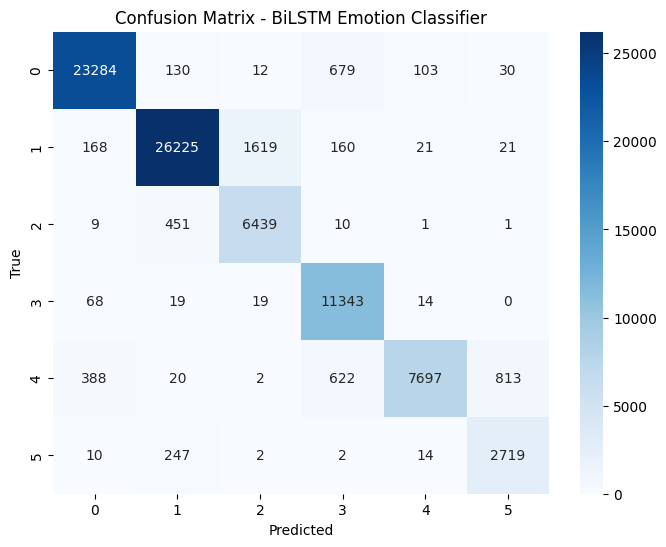

In [32]:
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(df['label'].unique()),
            yticklabels=sorted(df['label'].unique()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BiLSTM Emotion Classifier")
plt.show()

🔹 Insights

The model is strong on Joy, Sadness, and Anger (high diagonals, low confusion).

Joy vs Love → biggest confusion (semantically close emotions).

Fear sometimes confused with Sadness/Anger.

Surprise is the smallest class → performs okay but a bit noisy

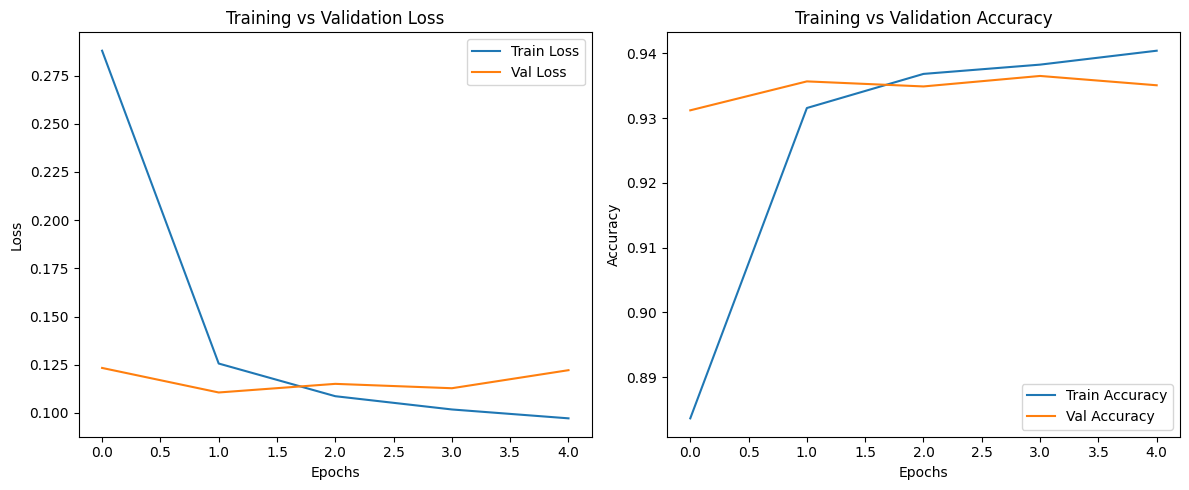

In [34]:
# Plot Loss & Accuracy curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


* Insights                                     
  ✅ No major overfitting → training & validation curves are close.

   ✅ Good generalization → validation accuracy stable & high.

🔹 Conclusion

Our BiLSTM is performing really well:

Accuracy ≈ 93.21%

Validation and training curves are almost parallel → stable model

we could even try slight hyperparameter tuning (e.g., more LSTM units, different batch size), but this performance is already excellent.

In [37]:
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("Macro F1-Score:", round(f1_macro, 4))
print("Weighted F1-Score:", round(f1_weighted, 4))

Macro F1-Score: 0.9033
Weighted F1-Score: 0.9327


In [38]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model (already saved as best_bilstm.h5 by checkpoint)